### 参考：https://www.kaggle.com/nitinsss/extracting-useful-data-from-the-mat-files


In [1]:
from scipy.io import loadmat
import pickle
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
import pywt
from sklearn import preprocessing   

In [2]:
fs = 128
n_subjects = 1
mkpt1 = int(fs*10*60)
mkpt2 = int(fs*20*60)

In [3]:
subject_map = {}
for s in range(1, n_subjects+1):
    a =  int(7*(s-1)) + 3
    if s!=5:
        b = a + 5
    else:
        b = a + 4
    subject_map[s] = [i for i in range(a, b)]
print(subject_map)

{1: [3, 4, 5, 6, 7]}


In [4]:
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
useful_channels = ['F7','F3','P7','O1','O2','P8','AF4']
#useful_channels = ['F7','F3','T7','P7','O1','O2','P8','T8','AF4']
use_channel_inds = []
for c in useful_channels:
    if c in channels:
        use_channel_inds.append(channels.index(c))

In [5]:
use_channel_inds

[1, 2, 5, 6, 7, 8, 13]

In [37]:
def WPFilter(data, fs, wavelet, maxlevel = 6):
    wp = pywt.WaveletPacket(data=data, wavelet=wavelet, mode='symmetric')
    # 频谱由低到高的对应关系，这里需要注意小波变换的频带排列默认并不是顺序排列，所以这里需要使用’freq‘排序。
    freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
    # 构造空的小波包
    new_wp = pywt.WaveletPacket(data=None, wavelet=wavelet, mode='symmetric')
    # 计算maxlevel最小频段的带宽
    freqBand = fs/(2**maxlevel)
    for i in range(len(freqTree)):
        # 第i个频段的最小频率
        bandMin = i * freqBand
        # 第i个频段的最大频率
        bandMax = bandMin + freqBand
        # 判断第i个频段是否在要分析的范围内
        if (0<=bandMin and 30>= bandMax):
            # 给新构造的小波包参数赋值
            new_wp[freqTree[i]] = wp[freqTree[i]].data
    return new_wp.reconstruct()




#     reconstract = [list(WPFilter(data[0], 128, 'db30', 6))]
#     for i in range(1, np.shape(data)[0]):
#         reconstract.extend([list(WPFilter(data[i], 128, 'db30', 6))])
#     reconstract = np.array(reconstract)

In [38]:
def getTimeSpectrum(data, wavelet='db4',maxlevel = 8, fs=128, fmax = 40, interval = 8, step = 2):
    freqBand = fs / (2 ** maxlevel)
    window_num = int(fmax / freqBand)
    
    # 10s 一分区  
    head = 0
    tail = head + interval*fs
    energy = []
    while (tail <= len(data)):
        wp = pywt.WaveletPacket(data=data[head:tail], wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
        freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
        # 初始化该通道下每个频带的能量数组
        iterEnergy = []
        # 对于每一个频带
        for j in range(1, window_num):
            iterEnergy.append(pow(np.linalg.norm(wp[freqTree[j]].data, ord=None), 2))
        # 合并
        energy.append(iterEnergy)
        # 修改指针
        head += step * fs
        tail = head + interval*fs
        
    min_max_scaler = preprocessing.MinMaxScaler()  
    energy = min_max_scaler.fit_transform(energy)
    #     # 对每一个船体时间内的数据进行归一化  效果很不好，别这样搞
#     min_max_scaler = preprocessing.MinMaxScaler()  
#     energy = min_max_scaler.fit_transform(np.transpose(energy))
#     energy = np.transpose(energy)
    return energy

In [39]:
def cleanData(data, wavelet='db4',maxlevel = 8, fs=128, fmax = 40, interval = 8, step = 2):
#     # 各通道数据归一化
#     data = np.transpose(data)
#     eeg_max = np.amax(data, 1)
#     eeg_min = np.min(data, 1)
#     eeg_mean = np.mean(data, 1)

#     for i in range(len(data)):
#         data[i] = (data[i] - eeg_min[i])/(eeg_max[i] - eeg_min[i])
    data = data[:, :30*60*fs]
    
#     # 滤波
#     info = mne.create_info(
#         ch_names=useful_channels,
#         ch_types=['eeg' for _ in range(0,len(useful_channels))],
#         sfreq=128
#     )
#     raw = mne.io.RawArray(data, info)
#     raw = raw.notch_filter(freqs=50) # 50Hz工频滤波
#     raw.filter(0.1, 40, fir_design='firwin') # 高通、低通滤波
#     data = raw.get_data()

    # 对每个通道，小波包分解重构,提取频带能量
    E =  []
    for i in range(np.shape(data)[0]):
        E.append(getTimeSpectrum(data[i], wavelet='db4',maxlevel = maxlevel, fs=fs, fmax = fmax, interval = interval, step = step))
    E = np.array(E)
    E = E.reshape([np.shape(E)[1] , np.shape(E)[0], np.shape(E)[2]],order='F')
    return E
    

In [6]:
inp_dir = '../../EEG Data/' 
for s in range(1, n_subjects+1):
    data = {}
    data['channels'] = useful_channels
    data['fs'] = fs
    for i, t in enumerate(subject_map[s]):
        trial = {}
        trial_data = loadmat(inp_dir + f'eeg_record{t}.mat')
        eeg = np.transpose(trial_data['o']['data'][0][0][:, 3:17])
        eeg = eeg[use_channel_inds]

In [7]:
eeg.shape

(7, 398816)

In [10]:
eeg[:,:10].shape

(7, 10)

In [12]:
t = eeg[:, fs*1*30:mkpt1-fs*1*30]
t

array([[3989.23076923, 3988.20512821, 3985.64102564, ..., 3973.84615385,
        3978.97435897, 3975.38461538],
       [5043.07692308, 5039.48717949, 5037.43589744, ..., 5047.17948718,
        5050.25641026, 5052.82051282],
       [4315.8974359 , 4316.41025641, 4313.84615385, ..., 4304.1025641 ,
        4309.23076923, 4304.1025641 ],
       ...,
       [4029.23076923, 4027.17948718, 4024.1025641 , ..., 4004.61538462,
        4011.28205128, 4014.87179487],
       [4169.74358974, 4168.71794872, 4168.20512821, ..., 4150.76923077,
        4154.87179487, 4152.30769231],
       [4163.07692308, 4159.48717949, 4153.33333333, ..., 4127.17948718,
        4125.64102564, 4126.15384615]])

In [13]:
t.shape

(7, 69120)

In [ ]:
# (n, 7, 128*2)


In [32]:
m = t.reshape((7,-1, 128*2), order = 'C').transpose(1,0,2)
m[0][1]

array([5043.07692308, 5039.48717949, 5037.43589744, 5036.41025641,
       5034.87179487, 5035.8974359 , 5037.94871795, 5036.92307692,
       5036.92307692, 5040.        , 5038.97435897, 5037.94871795,
       5038.46153846, 5038.97435897, 5038.46153846, 5041.02564103,
       5046.66666667, 5049.74358974, 5051.28205128, 5051.79487179,
       5051.28205128, 5045.64102564, 5042.05128205, 5048.20512821,
       5051.79487179, 5044.61538462, 5037.94871795, 5041.53846154,
       5042.05128205, 5036.41025641, 5033.84615385, 5037.94871795,
       5044.61538462, 5040.        , 5031.79487179, 5033.33333333,
       5038.46153846, 5041.02564103, 5041.53846154, 5039.48717949,
       5037.43589744, 5040.        , 5040.        , 5034.35897436,
       5030.25641026, 5027.17948718, 5027.17948718, 5026.66666667,
       5024.1025641 , 5022.56410256, 5018.97435897, 5015.8974359 ,
       5012.82051282, 5013.84615385, 5018.97435897, 5024.1025641 ,
       5023.07692308, 5016.92307692, 5012.82051282, 5013.84615

In [40]:
inp_dir = '../../EEG Data/' 
for s in range(1, n_subjects+1):
    data = {}
    data['channels'] = useful_channels
    data['fs'] = fs
    for i, t in enumerate(subject_map[s]):
        trial = {}
        trial_data = loadmat(inp_dir + f'eeg_record{t}.mat')
        eeg = np.transpose(trial_data['o']['data'][0][0][:, 3:17])
        eeg = eeg[use_channel_inds]
        #
        # 插入清洗函数，此时egg.shape = [:,7]
        interval = 8
        step = 2
        eeg = cleanData(eeg, wavelet='db4',maxlevel = 8, fs=128, fmax = 40, interval = interval, step = step)
        chunk_num = int(30*60 / step / 3)
        trash_num = int((20 - interval) / step)
        
#         # 取中间的8分钟
#         trial['focussed'] = eeg[fs*1*60 : mkpt1-fs*1*60]
#         trial['unfocussed'] = eeg[mkpt1+fs*1*60 : mkpt2-fs*1*60]
#         trial['drowsed'] = eeg[mkpt2+fs*1*60 : mkpt2+fs*9*60]

        trial['focussed'] = eeg[trash_num : chunk_num-trash_num]
        trial['unfocussed'] = eeg[chunk_num+trash_num : 2*chunk_num-trash_num]
        trial['drowsed'] = eeg[2*chunk_num+trash_num : 3*chunk_num-trash_num]
        
        data[f'trial_{i+1}'] = trial
    with open(f'../../EEG Data/Disposed/subject_{s}.pkl', 'wb') as f: 
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [93]:
# 查看数据

with open('../../EEG Data/Disposed/backup/trail_1/subject_1.pkl', 'rb') as f: 
    data = pickle.load(f)
data

{'channels': ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4'],
 'fs': 128,
 'trial_1': {'focussed': array([[[5.19924129e-01, 1.00000000e+00, 1.00000000e+00, ...,
           4.52533158e-01, 8.59960999e-02, 3.81404175e-01],
          [1.03257530e-01, 6.74642965e-02, 8.05555005e-02, ...,
           9.53741625e-02, 9.38748440e-02, 1.50040967e-01],
          [4.84445823e-02, 5.83947621e-03, 9.79479864e-03, ...,
           3.24384839e-02, 1.81095562e-01, 1.77192883e-01],
          ...,
          [1.44340234e-01, 2.31055672e-02, 8.69853004e-03, ...,
           7.40443601e-02, 1.36106846e-02, 4.48926837e-02],
          [4.15692530e-04, 4.50776847e-03, 5.79309715e-03, ...,
           3.89572720e-02, 1.07136211e-01, 6.01817027e-02],
          [1.42598160e-02, 2.97060085e-02, 2.05363805e-02, ...,
           2.00851668e-01, 2.07774266e-01, 4.00507082e-02]],
  
         [[4.12837615e-01, 3.97278809e-01, 1.00000000e+00, ...,
           9.95420056e-02, 5.05136532e-01, 5.94673068e-01],
          [1.8683867

In [94]:
np.shape(data['trial_1']['focussed'])

(56, 7, 79)

In [69]:
a = data['trial_1']['focussed'][:,2,:]

In [70]:
np.shape(a)

(296, 158)

In [81]:
a = data['trial_1']['focussed'][:,2,:]
a_avg = a.mean(axis=0)

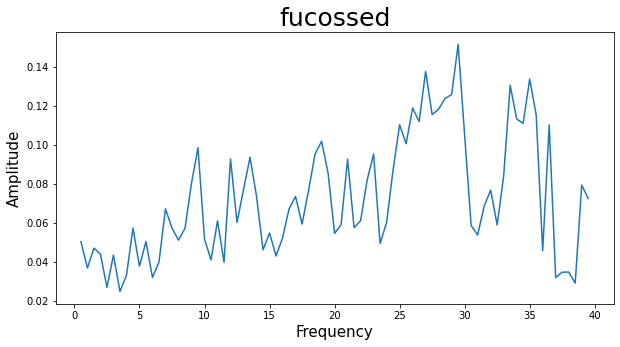

In [83]:
plt.figure(figsize=(10,5))
plt.title('fucossed', fontsize=25)
plt.xlabel('Frequency',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.plot([i/2 for i in range(1,80)],a_avg)
plt.show()

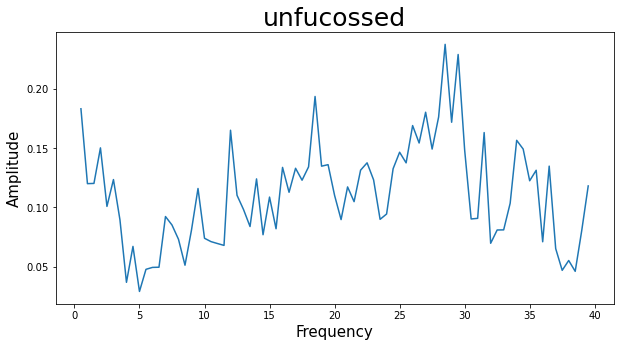

In [84]:
b = data['trial_1']['unfocussed'][:,2,:]
b_avg = b.mean(axis=0)
plt.figure(figsize=(10,5))
plt.title('unfucossed', fontsize=25)
plt.xlabel('Frequency',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.plot([i/2 for i in range(1,80)],b_avg)
plt.show()

In [75]:
print(data['trial_1']['unfocussed'])

[]


In [23]:
np.shape(data['trial_1']['focussed'])

(61440, 7)

##### 将5个人的实验数据放在一起